In [1]:
import getpass
if getpass.getuser() == 'mshaaban':
    import common_tools as ct
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai')
    jtplot.style(ticks=True, grid=False, figsize=(8, 4))
def hide(tex):
    return ct.hide_toggle(ttext=tex)
hide("shaaban_imports")

In [2]:
import numpy as np
import sys
import os
from astropy import units as u
from astropy import constants as const
from matplotlib import pyplot as plt
from pprint import pprint
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
from astropy.io import fits
import ccdproc as ccdp
import pickle
hide("imports")

# Astro Tools Examples

In this notebook I will work through examples illustrating how to use some standard astronomy tools, the tools we will focus on are:
- [Astrometry.Net](http://astrometry.net) : A lost in space code for solving fields.
- [Sextractor]() : A powerful/fast multiuse source extraction code
- [PSFEx]() : A code that operates on sextractor catalogs to extract a PSF model

Information on how to install these tools on ubuntu is provided below.

## Software Installation
---

### Astrometry.net Installation

- http://astrometry.net/use.html is the link to used
- downloaded the source from the link
- used make to build without a ./configure
  - issue with fitsio dependency
  - installed dependancies using
  ```bash
  sudo apt-get install libcairo2-dev libnetpbm10-dev netpbm
  sudo apt-get install libpng-dev libjpeg-dev python-numpy
  sudo apt-get install python-pyfits python-dev zlib1g-dev
  sudo apt-get install libbz2-dev swig libcfitsio-dev
  ```
  - one can also try run /doc/install_astrometry_on_linux.sh
  - missing GSL
    ### GSL
    ```bash
    wget ftp://ftp.gnu.org/gnu/gsl/gsl-*.*.tar.gz
    tar -zxvf gsl-*.*.tar.gz
    make
    sudo make install
    ```
- that diidnt work but the following worked `sudo apt-get remove astrometry.net`
- in the future might wanna try this link http://plaidhat.com/code/astrometry.php
- next have to set up the index files
  - download the index files from [here](http://astrometry.net/doc/readme.html#backend-config) (i downloaded both 4200 and 4100)
  - move them to /usr/local/astrometry/data/
  - add the path of indices to /etc/astrometry.cfg
- works!

### Sextractor

- Attempted to use ubuntu apt get to install did not succeed
- moved forward by using this link to install: https://sextractor.readthedocs.io/en/latest/Installing.html
- this led me to manual installation of fftw did it once with
  ### FFTW
  - Get source from http://www.fftw.org/ and unzip
  ```bash
  ./configure --enable-threads
  make && sudo make install
  ```
  - that was not enough so will redo a second time with
  ```bash
  ./configure --enable-single --enable-threads
  make && sudo make install
  ```
  - that worked no more fftw errors
- now need to install to continue
  ### ATLAS
  - instructions are found on (http://math-atlas.sourceforge.net/)
  - seems to be installable via ubuntu apt so will try
  ```bash
  sudo apt-get install libatlas-base-dev
  ```
- That worked!

### PSFEx

```bash
sudo apt-get install psfex
```


## Sample Data
---

All examples in this notebook will use images captured during SuperBIT's 2019 Timmins, ON flight. The data can be found on `bee.astro.utoronto.ca:/data2/superbit_2019/`.

The image used has already been bias and dark corrected but not flat corrected. In the snippet of code below we also remove cosmic rays. 

**Note: Field solving with astrometry.net WILL NOT WORK without cosmic hit removing**

In [3]:
# Get the sample image and prepare it for this analysis

# Path of parent directory of superbit data
data_path = "bit@bee.astro.utoronto.ca:/data2/superbit_2019/superbit_2019_cleaned_data/clean/" 

# Image that will be used
raw_img = "dwb_image_ifc_1568795115_12099_target_300.fits"
# install sshpass if you dont have it (sudo apt install sshpass )
# copy the image over to the directory of this notebook
!sshpass -p "bit2016" scp {data_path+raw_img} .

image_array = fits.getdata(raw_img) # get the image data as an array
header = fits.getheader(raw_img)
#satlevel = np.median(image_array[image_array >= 65530]) # roughly determine the saturation level
satlevel = 60000

# Remove cosmic rays (this is necessary in order to get successful lost in space astrometry)
cosmic_removed, mask = ccdp.cosmicray_lacosmic(image_array, gain=0.33, readnoise=12, satlevel=satlevel, objlim=7)
np.save("cosmic_mask.npy",mask) #save the cosmic mask locally

# save the cosmic cleaned image with the same header file as the origina as a seprate fits file
clean_img = "clean_dwb_image_ifc_1568795115_12099_target_300.fits"
hdu = fits.PrimaryHDU(data=cosmic_removed, header=header)
hdul = fits.HDUList([hdu])
hdul.writeto(clean_img, overwrite=True)

#delete unused variables
del image_array
del cosmic_removed
del mask
del header

hide("sample data preperation code")

/bin/bash: sshpass: command not found


112.34251569573283 104.75 470.7773624956235
36.41783 34.5675 141.90305
Peak = 3225722 FWHM =  64.93559999999707
112.34251569573283 104.75 470.7773624956235
Peak = 3233380 FWHM =  21.428751
36.41783 34.5675 141.90305


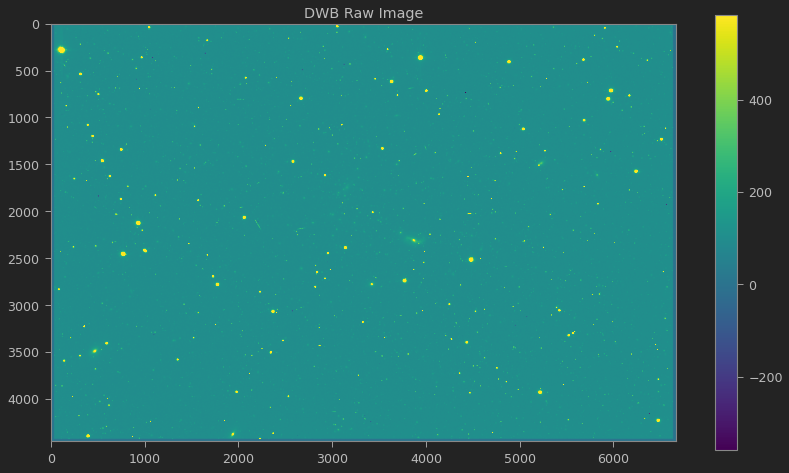

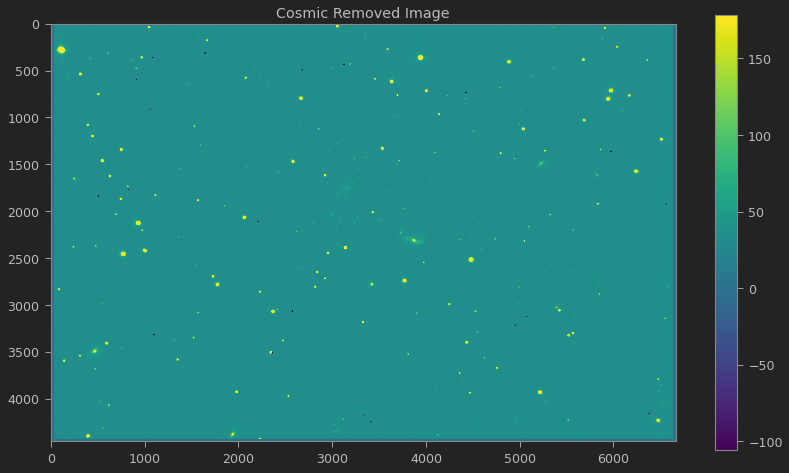

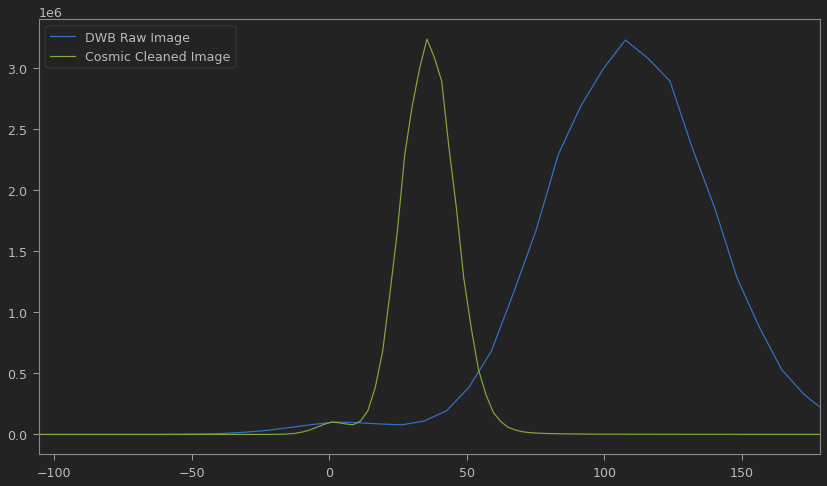

In [4]:
# Show the Data

# Get the arrays 
raw_arr = fits.getdata(raw_img)
clean_arr = fits.getdata(clean_img)

# Show the images
ct.plotimg(raw_arr,sig=1,title="DWB Raw Image")
ct.plotimg(clean_arr,sig=1, title= "Cosmic Removed Image")

# Plot image histograms
ct.plothist(raw_arr,bins=15000, label="DWB Raw Image")
ct.plothist(clean_arr,bins=15000,label="Cosmic Cleaned Image", nfig=False)

# Delete unused variables
del raw_arr
del clean_arr

hide("plot code")

## Astrometery.Net Examples
---

Solving fields in astrometry is a very simple command line operaiton 
```
solve-field [options] [<image-file-1> <image-file-2>]
```
below is the output of the help option.

In [5]:
! solve-field -h {clean_img} astrom_output

This program is part of the Astrometry.net suite.
For details, visit http://astrometry.net.
Git URL https://github.com/dstndstn/astrometry.net
Revision 0.78, date Mon_Apr_22_12:25:30_2019_-0400.

Usage:   solve-field [options]  [<image-file-1> <image-file-2> ...] [<xyls-file-1> <xyls-file-2> ...]

You can specify http:// or ftp:// URLs instead of filenames.  The "wget" or "curl" program will be used to retrieve the URL.

Options include:
  -h / --help: print this help message
  -v / --verbose: be more chatty -- repeat for even more verboseness
  -D / --dir <directory>: place all output files in the specified directory
  -o / --out <base-filename>: name the output files with this base name
  -b / --backend-config <filename>: use this config file for the
          "astrometry-engine" program
  --config <filename>: use this config file for the "astrometry-engine" program
  --batch: run astrometry-engine once, rather than once per input file
  -f / --files-on-stdin: read filenames to solve

In [6]:
# solve field given FOV of ~ 0.25deg x 0.4deg and store output in directory astrom_output
! solve-field {clean_img} --no-plots --scale-low 0.25 --scale-high 0.4 --dir astrom_output --overwrite

Reading input file 1 of 1: "clean_dwb_image_ifc_1568795115_12099_target_300.fits"...
Extracting sources...
simplexy: found 624 sources.
Solving...
Reading file "astrom_output/clean_dwb_image_ifc_1568795115_12099_target_300.axy"...
Field 1 did not solve (index index-4207-11.fits, field objects 1-10).
Field 1 did not solve (index index-4207-10.fits, field objects 1-10).
Field 1 did not solve (index index-4207-09.fits, field objects 1-10).
Field 1 did not solve (index index-4207-08.fits, field objects 1-10).
Field 1 did not solve (index index-4207-07.fits, field objects 1-10).
Field 1 did not solve (index index-4207-06.fits, field objects 1-10).
Field 1 did not solve (index index-4207-05.fits, field objects 1-10).
Field 1 did not solve (index index-4207-04.fits, field objects 1-10).
Field 1 did not solve (index index-4207-03.fits, field objects 1-10).
Field 1 did not solve (index index-4207-02.fits, field objects 1-10).
Field 1 did not solve (index index-4207-01.fits, field objects 1-10).

<h3>Output files<a class="headerlink" href="#output-files" title="Permalink to this headline"></a></h3>
<table border="1" class="docutils">
<colgroup>
<col width="25%" />
<col width="75%" />
</colgroup>
<tbody valign="top">
<tr class="row-odd"><td>&lt;base&gt;-ngc.png</td>
<td>an annotation of the image.</td>
</tr>
<tr class="row-even"><td>&lt;base&gt;.wcs</td>
<td>a FITS WCS header for the solution.</td>
</tr>
<tr class="row-odd"><td>&lt;base&gt;.new</td>
<td>a new FITS file containing the WCS header.</td>
</tr>
<tr class="row-even"><td>&lt;base&gt;-objs.png</td>
<td>a plot of the sources (stars) we extracted from
the image.</td>
</tr>
<tr class="row-odd"><td>&lt;base&gt;-indx.png</td>
<td>sources (red), plus stars from the index (green),
plus the skymark (“quad”) used to solve the
image.</td>
</tr>
<tr class="row-even"><td>&lt;base&gt;-indx.xyls</td>
<td>a FITS BINTABLE with the pixel locations of
stars from the index.</td>
</tr>
<tr class="row-odd"><td>&lt;base&gt;.rdls</td>
<td>a FITS BINTABLE with the RA,Dec of sources we
extracted from the image.</td>
</tr>
<tr class="row-even"><td>&lt;base&gt;.axy</td>
<td>a FITS BINTABLE of the sources we extracted, plus
headers that describe the job (how the image is
going to be solved).</td>
</tr>
<tr class="row-odd"><td>&lt;base&gt;.solved</td>
<td>exists and contains (binary) 1 if the field solved.</td>
</tr>
<tr class="row-even"><td>&lt;base&gt;.match</td>
<td>a FITS BINTABLE describing the quad match that
solved the image.</td>
</tr>
<tr class="row-odd"><td>&lt;base&gt;.kmz</td>
<td>(optional) KMZ file for Google Sky-in-Earth.  You need
to have “wcs2kml” in your PATH.  See
<a class="reference external" href="http://code.google.com/p/wcs2kml/downloads/list">http://code.google.com/p/wcs2kml/downloads/list</a>
<a class="reference external" href="http://code.google.com/p/google-gflags/downloads/list">http://code.google.com/p/google-gflags/downloads/list</a></td>
</tr>
</tbody>
</table>
</div>
</div>

The .new file opened in ds9 can serve as a good sanity check that you have the right coordinates, doing so and comparing to the wikipedia entry for Abell 2218 we find agreement this the solving works.

The header components we care about primarly are the following:
```
CRVAL1  =        249.169787833 / RA  of reference point                         
CRVAL2  =        66.2305777377 / DEC of reference point                         
CRPIX1  =        3961.51971436 / X reference pixel                              
CRPIX2  =        3067.28674316 / Y reference pixel                              
CUNIT1  = 'deg     ' / X pixel scale units                                      
CUNIT2  = 'deg     ' / Y pixel scale units                      
```
below is the header files of interest.

In [8]:
fits.getheader("astrom_output/clean_dwb_image_ifc_1568795115_12099_target_300.new")

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 6665                                                  
NAXIS2  =                 4453                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2019-09-18T08:25:21' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
IMG_X   =                 3333 / Frame center X coord. [px]                     
IMG_Y   =                 2227 / Frame center Y coord. [px]                     
IMG_W   =                 6666 / Frame width [px]                               
IMG_H   =                 4454 / Frame height [px]                              
OBSTYPE = 'Science '        

In [7]:
# path to lost in space solved image
solved_image  = "astrom_output/clean_dwb_image_ifc_1568795115_12099_target_300.new"

## Sextractor Examples
---

In [71]:
# make directories
! mkdir sex_output
! mkdir sex_inputs

### Sextractor Configuration

SExtractor is run from cmdline as follows:
```
sex <image> [<image2>][-c <configuration_file>][-<keyword> <value>]
> to dump a default configuration file:          sex -d 
> to dump a default extended configuration file: sex -dd 
> to dump a full list of measurement parameters: sex -dp 

```
The parts enclosed within brackets are optional. A configuration file is used for set up, (name).sex Any -Parameter Value statement in the command-line overrides the corresponding definition in the configuration file or any default value.

In [103]:
# below is code to get the defult config and param files
# ! sex -dd > sex_inputs/config.sex
# ! sex -dp > sex_inputs/default.param

Made the following modification to config.sex to reflect superbit info:
```
SATUR_LEVEL      60000        # level (in ADUs) at which arises saturation
GAIN             0.3            # detector gain in e-/ADU
PIXEL_SCALE      0           # size of pixel in arcsec (0=use FITS WCS info)
SEEING_FWHM      0.3           # stellar FWHM in arcsec

```

The next step is to uncomment the parameters you want extracted, in this example I extracted the following params:
```
NUMBER                   Running object number  
X_IMAGE                  Object position along x                                   [pixel]
Y_IMAGE                  Object position along y                                   [pixel]
ALPHAPEAK_J2000          Right ascension of brightest pix (J2000)                  [deg]
DELTAPEAK_J2000          Declination of brightest pix (J2000)                      [deg]
FLUX_AUTO                Flux within a Kron-like elliptical aperture               [count]
FLUXERR_AUTO             RMS error for AUTO flux                                   [count]
```

In [67]:
# path to sextractor catalog
cat = "sex_output/cat_" + "clean_dwb_image_ifc_1568795115_12099_target_300.new"

In [72]:
# run sextractor 
! sex {solved_image} -c sex_inputs/config.sex -CATALOG_NAME {cat}

> 
----- SExtractor 2.25.0 started on 2020-09-29 at 19:33:33 with 1 thread

> Setting catalog parameters
> Initializing catalog
> Looking for clean_dwb_image_ifc_1568795115_12099_target_300.new
----- Measuring from: clean_dwb_image_ifc_1568795115_12099_target_300.new
      " " / no ext. header / 6665x4453 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:   64
> Setting up background map at line:  128
> Setting up background map at line:  192
> Setting up background map at line:  256
> Setting up background map at line:  320
> Setting up background map at line:  384
> Setting up background map at line:  448
> Setting up background map at line:  512
> Setting up background map at line:  576
> Setting up background map at line:  640
> Setting up background map at line:  704
> Setting up background map at line:  768
> Setting up background map at line:  832
> Setting up background map at line:  896
> Setting up background map 

> Line: 1475  Objects:     8046 detected /     3082 sextracted
> Line: 1500  Objects:     8226 detected /     3201 sextracted
> Line: 1525  Objects:     8383 detected /     3301 sextracted
> Line: 1550  Objects:     8531 detected /     3390 sextracted
> Line: 1575  Objects:     8664 detected /     3500 sextracted
> Line: 1600  Objects:     8813 detected /     3620 sextracted
> Line: 1625  Objects:     8969 detected /     3716 sextracted
> Line: 1650  Objects:     9093 detected /     3802 sextracted
> Line: 1675  Objects:     9226 detected /     3892 sextracted
> Line: 1700  Objects:     9353 detected /     3994 sextracted
> Line: 1725  Objects:     9477 detected /     4091 sextracted
> Line: 1750  Objects:     9643 detected /     4216 sextracted
> Line: 1775  Objects:     9798 detected /     4330 sextracted
> Line: 1800  Objects:     9995 detected /     4466 sextracted
> Line: 1825  Objects:    10151 detected /     4583 sextracted
> Line: 1850  Objects:    10302 detected /     4694 sex

> Line: 4375  Objects:    24283 detected /    15303 sextracted
> Line: 4400  Objects:    24599 detected /    15558 sextracted
> Line: 4425  Objects:    26089 detected /    16337 sextracted

> WARNING: Deblending overflow for detection at 1,1

> Line: 4450  Objects:    26557 detected /    16389 sextracted
> Line: 4453  Objects:    26557 detected /    16400 sextracted
> Line: 4453  Objects:    26557 detected /    16800 sextracted
> Line: 4453  Objects:    26557 detected /    17200 sextracted
> Line: 4453  Objects:    26557 detected /    17600 sextracted
> Line: 4453  Objects:    26557 detected /    18000 sextracted
> Line: 4453  Objects:    26557 detected /    18400 sextracted
> Line: 4453  Objects:    26557 detected /    18800 sextracted
      Objects: detected 26557    / sextracted 19026           

> Closing files
> 
> All done (in 7.5 s: 594.9 lines/s , 2541.6 detections/s)


<h3>SExtractor parameter list<a class="headerlink" href="#measurement-parameter-list" title="Permalink to this headline"></a></h3>
<p>Below is an exhaustive list of all the measurement parameters known to
<strong class="program">SExtractor</strong>. Please refer to the next sections for a detailed description
of their meaning.</p>
<table border="1" class="colwidths-given targetparam docutils" id="id7">
</a></caption>
<colgroup>
<col width="27%" />
<col width="18%" />
<col width="55%" />
</colgroup>
<thead valign="bottom">
<tr class="row-odd"><th class="head">Name</th>
<th class="head">Unit</th>
<th class="head">Description</th>
</tr>
</thead>
<tbody valign="top">
<tr class="row-even"><td><span class="target" id="number">NUMBER</span></td>
<td>…</td>
<td>Running object number</td>
</tr>
<tr class="row-odd"><td><span class="target" id="id-parent">ID_PARENT</span></td>
<td>…</td>
<td>Parent ID (before deblending)</td>
</tr>
<tr class="row-even"><td><span class="target" id="ext-number">EXT_NUMBER</span></td>
<td>…</td>
<td>FITS extension number</td>
</tr>
<tr class="row-odd"><td><span class="target" id="flags">FLAGS</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#flags-def"><span class="std std-ref">Source extraction flags</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="flags-weight">FLAGS_WEIGHT</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#flags-weight-def"><span class="std std-ref">Weighting flags</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="imaflags-iso">IMAFLAGS_ISO</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#imaflags-iso-def"><span class="std std-ref">External flags combined within the isophotal footprint</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="nimaflags-iso">NIMAFLAGS_ISO</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#imaflags-iso-def"><span class="std std-ref">Number of combined external flags</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="flux-iso">FLUX_ISO</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#flux-iso-def"><span class="std std-ref">Isophotal flux</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="fluxerr-iso">FLUXERR_ISO</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#flux-iso-def"><span class="std std-ref">RMS error estimate for the isophotal flux</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="mag-iso">MAG_ISO</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#flux-iso-def"><span class="std std-ref">Isophotal magnitude</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="magerr-iso">MAGERR_ISO</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#flux-iso-def"><span class="std std-ref">RMS error estimate for the isophotal magnitude</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="flux-isocor">FLUX_ISOCOR</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#mag-isocor-def"><span class="std std-ref">Corrected isophotal flux</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="fluxerr-isocor">FLUXERR_ISOCOR</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#mag-isocor-def"><span class="std std-ref">RMS error estimate for the corrected isophotal flux</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="mag-isocor">MAG_ISOCOR</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#mag-isocor-def"><span class="std std-ref">Corrected isophotal magnitude</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="magerr-isocor">MAGERR_ISOCOR</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#mag-isocor-def"><span class="std std-ref">RMS error estimate for the corrected isophotal magnitude</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="flux-aper">FLUX_APER</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#flux-aper-def"><span class="std std-ref">Flux(es) within fixed circular aperture(s)</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="fluxerr-aper">FLUXERR_APER</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#flux-aper-def"><span class="std std-ref">RMS error estimate(s) for the flux(es) within fixed circular aperture(s)</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="mag-aper">MAG_APER</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#flux-aper-def"><span class="std std-ref">Circular aperture magnitude(s)</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="magerr-aper">MAGERR_APER</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#flux-aper-def"><span class="std std-ref">RMS error estimate(s) for circular aperture magnitude(s)</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="flux-auto">FLUX_AUTO</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#flux-auto-def"><span class="std std-ref">Kron-like automated aperture flux</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="fluxerr-auto">FLUXERR_AUTO</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#flux-auto-def"><span class="std std-ref">RMS error estimate for Kron-like automated aperture flux</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="mag-auto">MAG_AUTO</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#flux-auto-def"><span class="std std-ref">Kron-like automated aperture magnitude</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="magerr-auto">MAGERR_AUTO</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#flux-auto-def"><span class="std std-ref">RMS error estimate for Kron-like automated aperture magnitude</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="kron-radius">KRON_RADIUS</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#flux-auto-def"><span class="std std-ref">Kron radius in units of A or B</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="flux-petro">FLUX_PETRO</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#flux-petro-def"><span class="std std-ref">Petrosian-like aperture flux</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="fluxerr-petro">FLUXERR_PETRO</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#flux-petro-def"><span class="std std-ref">RMS error estimate for Petrosian-like aperture flux</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="mag-petro">MAG_PETRO</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#flux-petro-def"><span class="std std-ref">Petrosian-like aperture magnitude</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="magerr-petro">MAGERR_PETRO</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#flux-petro-def"><span class="std std-ref">RMS error estimate for Petrosian-like aperture magnitude</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="petro-radius">PETRO_RADIUS</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#flux-petro-def"><span class="std std-ref">Petrosian radius in units of A or B</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="background">BACKGROUND</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#background-def"><span class="std std-ref">Background level at the position of the centroid</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="x-image">X_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="#image-coords"><span class="std std-ref">Pixel x coordinate</span></a> of the <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="y-image">Y_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="#image-coords"><span class="std std-ref">Pixel y coordinate</span></a> of the <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="x-focal">X_FOCAL</span></td>
<td>degree</td>
<td><a class="reference internal" href="#focal-coords"><span class="std std-ref">Focal plane x coordinate</span></a> of <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="y-focal">Y_FOCAL</span></td>
<td>degree</td>
<td><a class="reference internal" href="#focal-coords"><span class="std std-ref">Focal plane y coordinate</span></a> of <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="x-world">X_WORLD</span></td>
<td>…</td>
<td><a class="reference internal" href="#world-coords"><span class="std std-ref">World x coordinate</span></a> of the <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="y-world">Y_WORLD</span></td>
<td>…</td>
<td><a class="reference internal" href="#world-coords"><span class="std std-ref">World y coordinate</span></a> of the <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="alpha-sky">ALPHA_SKY</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">Native right ascension</span></a> of the <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="delta-sky">DELTA_SKY</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">Native declination</span></a> of the <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="alpha-j2000">ALPHA_J2000</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">J2000 right ascension</span></a> of the <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="delta-j2000">DELTA_J2000</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">J2000 declination</span></a> of the <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="alpha-b1950">ALPHA_B1950</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">B1950 right ascension</span></a> of the <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="delta-b1950">DELTA_B1950</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">B1950 declination</span></a> of the <a class="reference internal" href="index.html#pos-iso-def"><span class="std std-ref">isophotal image centroid</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="errx2-image">ERRX2_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#poserr-iso-def"><span class="std std-ref">Estimated variance of isophotal image centroid x coordinate</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="erry2-image">ERRY2_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#poserr-iso-def"><span class="std std-ref">Estimated variance of isophotal image centroid y coordinate</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="errxy-image">ERRXY_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#poserr-iso-def"><span class="std std-ref">Estimated covariance of isophotal image centroid x and y coordinates</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="erra-image">ERRA_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#poserr-iso-def"><span class="std std-ref">Major axis of the isophotal image centroid error ellipse</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="errb-image">ERRB_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#poserr-iso-def"><span class="std std-ref">Minor axis of the isophotal image centroid error ellipse</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="errtheta-image">ERRTHETA_IMAGE</span></td>
<td>degree</td>
<td><a class="reference internal" href="index.html#poserr-iso-def"><span class="std std-ref">Position angle of the isophotal image centroid ellipse</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="errcxx-image">ERRCXX_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#poserr-iso-def"><span class="std std-ref">Isophotal image centroid Cxx error ellipse parameter</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="errcyy-image">ERRCYY_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#poserr-iso-def"><span class="std std-ref">Isophotal image centroid Cyy error ellipse parameter</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="errcxy-image">ERRCXY_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#poserr-iso-def"><span class="std std-ref">Isophotal image centroid Cxy error ellipse parameter</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="xpeak-image">XPEAK_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="#image-coords"><span class="std std-ref">Pixel x coordinate</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="ypeak-image">YPEAK_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="#image-coords"><span class="std std-ref">Pixel y coordinate</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="xpeak-focal">XPEAK_FOCAL</span></td>
<td>degree</td>
<td><a class="reference internal" href="#focal-coords"><span class="std std-ref">Focal plane x coordinate</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="ypeak-focal">YPEAK_FOCAL</span></td>
<td>degree</td>
<td><a class="reference internal" href="#focal-coords"><span class="std std-ref">Focal plane y coordinate</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="xpeak-world">XPEAK_WORLD</span></td>
<td>…</td>
<td><a class="reference internal" href="#world-coords"><span class="std std-ref">World x coordinate</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="ypeak-world">YPEAK_WORLD</span></td>
<td>…</td>
<td><a class="reference internal" href="#world-coords"><span class="std std-ref">World y coordinate</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="alphapeak-sky">ALPHAPEAK_SKY</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">Native right ascension</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="deltapeak-sky">DELTAPEAK_SKY</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">Native declination</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="alphapeak-j2000">ALPHAPEAK_J2000</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">J2000 right ascension</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="deltapeak-j2000">DELTAPEAK_J2000</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">J2000 declination</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="alphapeak-b1950">ALPHAPEAK_B1950</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">J2000 right ascension</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="deltapeak-b1950">DELTAPEAK_B1950</span></td>
<td>degree</td>
<td><a class="reference internal" href="#sky-coords"><span class="std std-ref">J2000 declination</span></a> of the <a class="reference internal" href="index.html#pospeak-def"><span class="std std-ref">brightest pixel</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="xmin-image">XMIN_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#xyminmax-def"><span class="std std-ref">Minimum x coordinate among detected pixels</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="ymin-image">YMIN_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#xyminmax-def"><span class="std std-ref">Minimum y coordinate among detected pixels</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="xmax-image">XMAX_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#xyminmax-def"><span class="std std-ref">Maximum x coordinate among detected pixels</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="ymax-image">YMAX_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#xyminmax-def"><span class="std std-ref">Maximum y coordinate among detected pixels</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="xwin-image">XWIN_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#pos-win-def"><span class="std std-ref">x coordinate of windowed image centroid</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="ywin-image">YWIN_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#pos-win-def"><span class="std std-ref">y coordinate of windowed image centroid</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="errx2win-image">ERRX2WIN_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#poserr-win-def"><span class="std std-ref">Estimated variance of windowed image centroid x coordinate</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="erry2win-image">ERRY2WIN_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#poserr-win-def"><span class="std std-ref">Estimated variance of windowed image centroid y coordinate</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="errxywin-image">ERRXYWIN_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#poserr-win-def"><span class="std std-ref">Estimated covariance of windowed image centroid x and y coordinates</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="errawin-image">ERRAWIN_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#poserr-win-def"><span class="std std-ref">Major axis of the windowed image centroid error ellipse</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="errbwin-image">ERRBWIN_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#poserr-win-def"><span class="std std-ref">Minor axis of the windowed image centroid error ellipse</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="errthetawin-image">ERRTHETAWIN_IMAGE</span></td>
<td>degree</td>
<td><a class="reference internal" href="index.html#poserr-win-def"><span class="std std-ref">Position angle of the windowed image centroid ellipse</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="errcxxwin-image">ERRCXXWIN_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#poserr-win-def"><span class="std std-ref">Windowed image centroid Cxx error ellipse parameter</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="errcyywin-image">ERRCYYWIN_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#poserr-win-def"><span class="std std-ref">Windowed image centroid Cyy error ellipse parameter</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="errcxywin-image">ERRCXYWIN_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#poserr-win-def"><span class="std std-ref">Windowed image centroid Cxy error ellipse parameter</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="flags-win">FLAGS_WIN</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#flags-win-def"><span class="std std-ref">Windowed measurement flags</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="x2-image">X2_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#moments-iso-def"><span class="std std-ref">Isophotal image 2nd order central moment in x</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="y2-image">Y2_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#moments-iso-def"><span class="std std-ref">Isophotal image 2nd order central moment in y</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="xy-image">XY_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#moments-iso-def"><span class="std std-ref">Isophotal image 2nd order central cross-moment in xy</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="a-image">A_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#shape-iso-def"><span class="std std-ref">Isophotal image major axis</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="b-image">B_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#shape-iso-def"><span class="std std-ref">Isophotal image minor axis</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="theta-image">THETA_IMAGE</span></td>
<td>degree</td>
<td><a class="reference internal" href="index.html#shape-iso-def"><span class="std std-ref">Isophotal image position angle</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="elongation">ELONGATION</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#elong-iso-def"><span class="std std-ref">A_IMAGE / B_IMAGE</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="ellipticity">ELLIPTICITY</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#elong-iso-def"><span class="std std-ref">1 - B_IMAGE / A_IMAGE</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="cxx-image">CXX_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#ellipse-iso-def"><span class="std std-ref">Isophotal image Cxx ellipse parameter</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="cyy-image">CYY_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#ellipse-iso-def"><span class="std std-ref">Isophotal image Cyy ellipse parameter</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="cxy-image">CXY_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#ellipse-iso-def"><span class="std std-ref">Isophotal image Cxy ellipse parameter</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="isoareaf-image">ISOAREAF_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#isoarea-def"><span class="std std-ref">Isophotal area (filtered) above Detection threshold</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="isoarea-image">ISOAREA_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#isoarea-def"><span class="std std-ref">Isophotal area above Analysis threshold</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="x2win-image">X2WIN_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#moments-win-def"><span class="std std-ref">Windowed image 2nd order central moment in x</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="y2win-image">Y2WIN_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#moments-win-def"><span class="std std-ref">Windowed image 2nd order central moment in y</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="xywin-image">XYWIN_IMAGE</span></td>
<td>pixel<sup>2</sup></td>
<td><a class="reference internal" href="index.html#moments-win-def"><span class="std std-ref">Windowed image 2nd order central cross-moment in xy</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="cxxwin-image">CXXWIN_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#ellipse-win-def"><span class="std std-ref">Windowed image Cxx ellipse parameter</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="cyywin-image">CYYWIN_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#ellipse-win-def"><span class="std std-ref">Windowed image Cyy ellipse parameter</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="cxywin-image">CXYWIN_IMAGE</span></td>
<td>pixel<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#ellipse-win-def"><span class="std std-ref">Windowed image Cxy ellipse parameter</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="awin-image">AWIN_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#shape-win-def"><span class="std std-ref">Windowed image major axis</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="bwin-image">BWIN_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#shape-win-def"><span class="std std-ref">Windowed image minor axis</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="thetawin-image">THETAWIN_IMAGE</span></td>
<td>degree</td>
<td><a class="reference internal" href="index.html#shape-win-def"><span class="std std-ref">Windowed image position angle</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="class-star">CLASS_STAR</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#class-star-def"><span class="std std-ref">Star/galaxy classifier</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="vector-model">VECTOR_MODEL</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">Model-fitting coefficients</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="vector-modelerr">VECTOR_MODELERR</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">Model-fitting coefficient uncertainties</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="matrix-modelerr">MATRIX_MODELERR</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#model-minimization-def"><span class="std std-ref">Model-fitting covariance matrix</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="chi2-model">CHI2_MODEL</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#model-minimization-def"><span class="std std-ref">Reduced modified Chi2 of the fit</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="flags-model">FLAGS_MODEL</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#model-minimization-def"><span class="std std-ref">Model-fitting flags</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="niter-model">NITER_MODEL</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#model-minimization-def"><span class="std std-ref">Number of model-fitting iterations</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="flux-model">FLUX_MODEL</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">Flux from model-fitting</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="fluxerr-model">FLUXERR_MODEL</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">RMS error estimate for the model-fitting flux</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="mag-model">MAG_MODEL</span></td>
<td>magnitude</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">Magnitude from model-fitting</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="magerr-model">MAGERR_MODEL</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">RMS error estimate for the model-fitting magnitude</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="flux-max-model">FLUX_MAX_MODEL</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">Peak model flux above the background</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="flux-eff-model">FLUX_EFF_MODEL</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">Effective model flux above the background</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="flux-mean-model">FLUX_MEAN_MODEL</span></td>
<td>count</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">Mean effective model flux above the background</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="mu-max-model">MU_MAX_MODEL</span></td>
<td>mag.arcsec<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">Peak model surface brightness above the background</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="mu-eff-model">MU_EFF_MODEL</span></td>
<td>mag.arcsec<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">Effective model surface brightness above the background</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="mu-mean-model">MU_MEAN_MODEL</span></td>
<td>mag.arcsec<sup>-2</sup></td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">Mean effective model surface brightness above the background</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="xmodel-image">XMODEL_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">x coordinate from model-fitting</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="ymodel-image">YMODEL_IMAGE</span></td>
<td>pixel</td>
<td><a class="reference internal" href="index.html#models-def"><span class="std std-ref">y coordinate from model-fitting</span></a></td>
</tr>
<tr class="row-even"><td><span class="target" id="spread-model">SPREAD_MODEL</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#spread-model-def"><span class="std std-ref">Spread parameter from model-fitting</span></a></td>
</tr>
<tr class="row-odd"><td><span class="target" id="spreaderr-model">SPREADERR_MODEL</span></td>
<td>…</td>
<td><a class="reference internal" href="index.html#spread-model-def"><span class="std std-ref">RMS error estimate on spread parameter from model-fitting</span></a></td>
</tr>
</tbody>
</table>
</div>
</div>
</div>
</div>

In [77]:
#   1 NUMBER                 Running object number                                     
#   2 X_IMAGE                Object position along x                                    [pixel]
#   3 Y_IMAGE                Object position along y                                    [pixel]
#   4 ALPHAPEAK_J2000        Right ascension of brightest pix (J2000)                   [deg]
#   5 DELTAPEAK_J2000        Declination of brightest pix (J2000)                       [deg]
#   6 FLUX_AUTO              Flux within a Kron-like elliptical aperture                [count]
#   7 FLUXERR_AUTO           RMS error for AUTO flux                                    [count]
#   8 XPEAK_IMAGE            x-coordinate of the brightest pixel                        [pixel]
#   9 YPEAK_IMAGE            y-coordinate of the brightest pixel                        [pixel]
#  10 SNR_WIN                Gaussian-weighted SNR                                    

In [73]:
cat = np.loadtxt("sex_output/cat_clean_dwb_image_ifc_1568795115_12099_target_300.new")
np.shape(cat)

(19026, 10)

## PSFEx Example
---

## Useful Functions for Interfacing
---